In [5]:
import sys
import glob
import re
import fnmatch
import math
import re
import os
from os import listdir
from os.path import join, isfile, basename

import itertools

import numpy as np
from numpy import float32, int32, uint8, dtype, genfromtxt

import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, FormatStrFormatter

from sklearn.linear_model import LinearRegression

import seaborn as sns

import colorsys

import template_common as tc

In [6]:
dist_df, jac_df, hess_df, timeMem_df = tc.readStatTables()
grouped_label_table = tc.groupTables( dist_df, jac_df, hess_df, timeMem_df  )

/groups/saalfeld/home/bogovicj/dev/template/template-building-pub/python/template_common.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  jac_table['TEMPLATE'] = jac_table.apply(lambda x: template_name(x['TEMPLATE']), axis=1)
/groups/saalfeld/home/bogovicj/dev/template/template-building-pub/python/template_common.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  jac_table['ALG'] = jac_table.apply(lambda x: alg_name(x['ALG']), axis=1)
/groups/saalfeld/home/bogovicj/dev/template/template-building-pub/python/template_common.py:219: Se

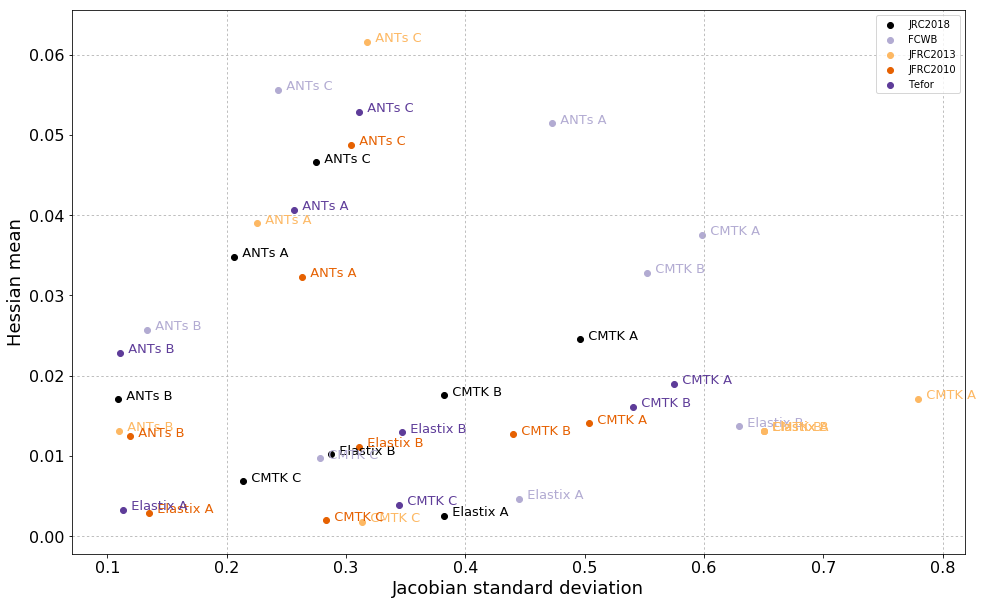

In [7]:
# Compare hessian mean and jacobian std

ax = tc.make_scatter_plot( grouped_label_table, 'JAC_std', 'HES_mean' )
ax.yaxis.set_minor_locator( MultipleLocator(0.02) )
ax.xaxis.set_minor_locator( MultipleLocator(0.2) )
plt.grid( which='minor', linestyle=':', dashes=(3,3))
    
plt.xlabel('Jacobian standard deviation', size=18)
plt.ylabel('Hessian mean', size=18)
fig = plt.gcf()
a = fig.set_size_inches( 16, 10 ) 

In [8]:
def linFitsByTemplate( template, xcolname, ycolname ):
    template_table = grouped_label_table[ grouped_label_table.TEMPLATE == template ]
    reg = LinearRegression()
    reg.fit( template_table[xcolname].values.reshape(-1, 1), template_table[ycolname].values.reshape(-1, 1) )
    return reg


fitJacDistByTemplate = {}
fitHesDistByTemplate = {}
for t in [tc.template_name(t) for t in tc.template_list ]:
    
    regj = linFitsByTemplate( t, 'JAC_std', 'DISTANCE_mean' )
    fitJacDistByTemplate[t] = regj
    
    regh = linFitsByTemplate( t, 'HES_mean', 'DISTANCE_mean' )
    fitHesDistByTemplate[t] = regh
    
    print( 'template: {}'.format(t))
    print( 'JAC:')
    print( '  slope = {}   intercept = {}'.format(regj.coef_[0], regj.intercept_))
    print( 'HES:')
    print( '  slope = {}   intercept = {}'.format(regh.coef_[0], regh.intercept_))
    print( ' ' )
    

template: JFRC2013
JAC:
  slope = [-0.60447149]   intercept = [4.89727243]
HES:
  slope = [0.16725003]   intercept = [4.61434742]
 
template: JFRC2010
JAC:
  slope = [2.84424981]   intercept = [4.28532775]
HES:
  slope = [10.08185229]   intercept = [4.95220829]
 
template: Tefor
JAC:
  slope = [2.77120323]   intercept = [3.87559119]
HES:
  slope = [-6.65292149]   intercept = [4.91809239]
 
template: JRC2018
JAC:
  slope = [-0.65681548]   intercept = [4.34559278]
HES:
  slope = [5.76550108]   intercept = [4.03729096]
 
template: FCWB
JAC:
  slope = [0.65561452]   intercept = [4.98616856]
HES:
  slope = [-16.55366479]   intercept = [5.7390409]
 


In [9]:
def plotFit( ax, fit, plotopts={}, minx=None, maxx=None ):
    if( minx is None ):
        minx = ax.get_xlim()[0]
    
    if( maxx is None ):
        maxx = ax.get_xlim()[1]
        
    linex = np.array([minx, maxx])
    liney = fit.predict( linex.reshape(-1,1) )
    plt.gca().plot(linex, liney, **plotopts )


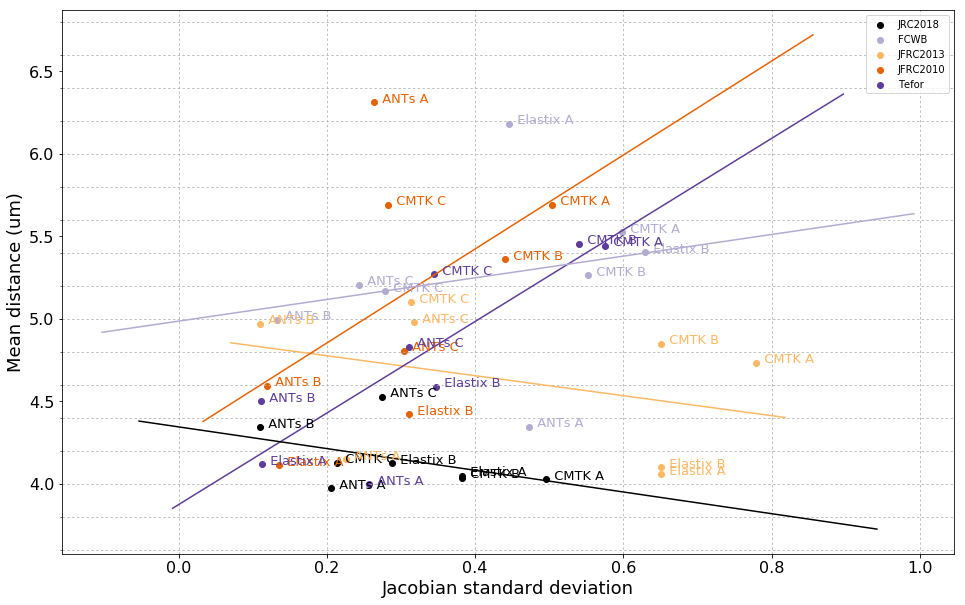

In [12]:
minx = 0.1
maxx = 0.75

ax = tc.make_scatter_plot( grouped_label_table, 'JAC_std', 'DISTANCE_mean' )
ax.yaxis.set_minor_locator( MultipleLocator(0.2) )
ax.xaxis.set_minor_locator( MultipleLocator(0.2) )
plt.grid( which='minor', linestyle=':', dashes=(3,3))
    
plt.xlabel('Jacobian standard deviation', size=18)
plt.ylabel('Mean distance (um)', size=18)
fig = plt.gcf()
a = fig.set_size_inches( 16, 10 )

for t in tc.template_list_mapped:
    plotFit( plt.gca(), fitJacDistByTemplate[t], 
            plotopts={'color' :tc.template_color_map[t]} )

# plotFit( plt.gca(), fitJacDistByTemplate['JRC2018'], plotopts={'color' : 'k'} )


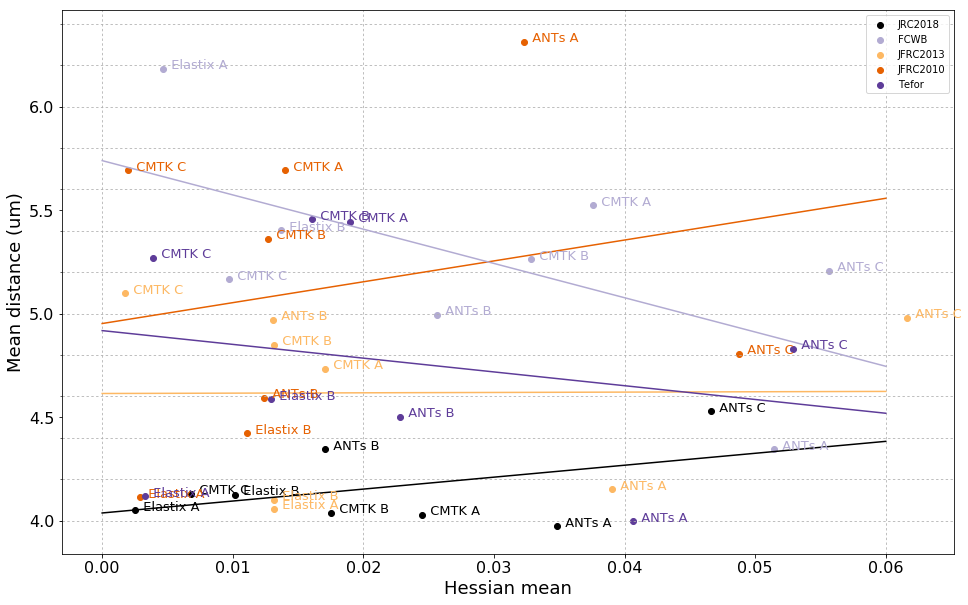

In [16]:
ax = tc.make_scatter_plot( grouped_label_table, 'HES_mean', 'DISTANCE_mean' )
ax.yaxis.set_minor_locator( MultipleLocator(0.2) )
ax.xaxis.set_minor_locator( MultipleLocator(0.02) )
plt.grid( which='minor', linestyle=':', dashes=(3,3))
    
plt.xlabel('Hessian mean', size=18)
plt.ylabel('Mean distance (um)', size=18)
fig = plt.gcf()
a = fig.set_size_inches( 16, 10 ) 

for t in tc.template_list_mapped:
    plotFit( plt.gca(), fitHesDistByTemplate[t], 
            plotopts={'color' :tc.template_color_map[t]},
            minx=0.0, maxx = 0.06 )


## Smoothness as a cost 

Compare templates by measuring the average "cost" in smoothness one has to pay (by modifying the registration algorithm) in order to achieve a particular increase in performance (decrease in the distance measure).

We'll measure that for a given template by fitting a line to points (x,y) where x is a smoothness measure and y is a quality measure

## Time as a cost 

Compare templates by measuring the average "cost" in time one has to pay (by modifying the registration algorithm) in order to achieve a particular increase in performance (decrease in the distance measure).
